# Supervised Learning

## Librerie

In [19]:
import os
import re
import string
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer 

from collections import Counter

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import shuffle

from sklearn.cluster import DBSCAN, KMeans

from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.manifold import TSNE



In [ ]:
### Da eseguire solo la prima volta
#nltk.download("stopwords")
#nltk.download('wordnet')

## Pre Processing

Il primo passo per lo sviluppo della classificazione consiste nella definizione delle operazioni di pre-processing; definiamo quindi la funzione preprocText(), la quale prende in input un documento in linguaggio naturale, lo traduce in inglese, splitta i singoli termini, rende tutti i caratteri minuscoli e applica una tokenizzazione. Dopo tali operazione viene applicata la rimozione delle stopwords e la lemmatization.

In [2]:
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

In [3]:
#Stop Words Download, run just once
#nltk.download('stopwords')

def preprocText(text):
    text = re.sub(r'\d', '', text)
    text = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)
    text = text.translate(str.maketrans('','',string.punctuation)).lower()
    tokenized_text = WordPunctTokenizer().tokenize(text)

    ##REMOVING STOPWORDS
    tokenized_text_without_stopwords = []
    for token in tokenized_text:
        if token not in stop_words:
            token = lemmatizer.lemmatize(token)
            if(len(token)) > 2:
                tokenized_text_without_stopwords.append(token)
        
    return tokenized_text_without_stopwords

A questo punto è possibile importare i dati d'interesse; dalla base di dati iniziali vengono conservati solo il copione e il genere, e si applica un filtraggio per mantenere solo i ilm drammatici, d'azione, le commedie, gli horror e i documentari. Tali generi rappresenteranno le label impiegate per la classificazione.

In [4]:
df = pd.read_csv('final.csv')
genresToKeep = ['Drama','Comedy','Action','Horror','Documentary']
df = df[df['Genres'].isin(genresToKeep)]
#df = df.iloc[0:4000]
df.Genres.value_counts()

Drama          5436
Comedy         3624
Action         2456
Horror         1760
Documentary    1179
Name: Genres, dtype: int64

Come si può notare vi è un significativo sbilanciamento all'interno dei generi, con Drama che presenta la frequenze maggiore e Documentary quella minore. Come sistema per risolvere tale sbilanciamento (il quale può portare ad una valutazione dell'accuratezza errata) si applica l'undersampling per riportare ciascuna classe all dimensione della minore (1179).

In [5]:
from imblearn.under_sampling import RandomUnderSampler

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

rus = RandomUnderSampler(replacement=False)
X, y= rus.fit_sample(X, y)
y.value_counts()

Documentary    1179
Action         1179
Drama          1179
Horror         1179
Comedy         1179
Name: Genres, dtype: int64

In [6]:
#Selezioni i primi n film
n = len(X)
docs_raw = X.filmScript
n = len(docs_raw)

A questo punto si applica la funzione di pre-processing inizialmente definita all'intero corpus; tale operazione risulterà necessaria per l'applicazione del Word Embedding.

In [7]:
processedScripts = [preprocText(item) for item in docs_raw]

##  Features Extraction

La features extraction risulta il procedimento più importante della classificazione; al fine di considerare diverse opzioni vegono definite di seguito 3 tecniche di Word Embedding:  
- Doc2Vec
- Truncated Singular Value Decomposition (TSVD) sulla Term-Frequency (TF) e sulla Term-Frequency Inverse-Document-frequency (TFIDF)  
- Glove

Dopo una serie di simulazioni il GloVe risulta il più efficiente.

### Doc2Vec

In [8]:
%%time
#Circa 5 min per runnare
#hyper-parameters Word2Vec
n_features = 300
window_length = 5 

#Ceo TaggedDocument necessario a gensim per il modello word2vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(processedScripts)]
#deploy e training del modello
model = Doc2Vec(documents, vector_size=n_features, window=window_length, min_count=1)
#Costruisco matrice finale
Doc2Vec = []
for i in range(0,n):
    Doc2Vec.append(model[i])
Doc2Vec = np.array(Doc2Vec)
print("Word2Vec Matrix shape: ", Doc2Vec.shape)

Word2Vec Matrix shape:  (5895, 300)
Wall time: 4min 41s


### Singular Value Decomposition a partire da TF e TFIDF

In [9]:
%%time
#Frequency
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(docs_raw)

#tfidf
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)


C:\Users\Pietro\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1796: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


Wall time: 55.7 s


In [10]:
%%time
## TF performa leggermente meglio di TFIDF, in generale SVD decisamente meglio di Word2Vec ma leggermente peggiore di GloVe
pca = TruncatedSVD(n_components=200)
dataTF = pca.fit_transform(dtm_tf)
dataTFIDF = pca.fit_transform(dtm_tfidf)

Wall time: 38.5 s


### GloVe

In [11]:
#CONVERTE GLOVE A WORD2VEC PER ESSERE UTILIZZATO DA GENSIM, DA RUNNARE 1 SOLA VOLTA PER OTTENERE IL FILE

#from gensim.scripts.glove2word2vec import glove2word2vec
#glove_input_file = 'glove.6B.200d.txt'
#word2vec_output_file = 'glove.6B.200d.txt.word2vec'
#glove2word2vec(glove_input_file, word2vec_output_file)

#Carico il modello
from gensim.models import KeyedVectors
filename = 'glove.6B.200d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)


#Test: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.6978678703308105)]


In [12]:
#ESTRAGGO VETTORE GLOVE DEL DOCUMENTO A PARTIRE DAI VETTORI DELLE SIGNOLE PAROLE
#Se la parola non è presente del vocabolario passo array di 0
GloVe = []
for document in processedScripts:
    documentRepr = []
    for word in document:
        try:
            documentRepr.append(model.get_vector(word))
        except Exception:
            documentRepr.append( np.zeros(200))
    GloVe.append( np.mean(np.array(documentRepr),axis=0) )
GloVe = np.array(GloVe)
GloVe.shape

(5895, 200)

## Definizione Training e Test

A partire dal GloVe vengono definiti training e test sia per le features, sia per le labels

#### Standardizzazione

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#dataTF = scaler.fit_transform(dataTF)
#dataTFIDF = scaler.fit_transform(dataTFIDF)
#dataW2V = scaler.fit_transform(Doc2Vec)
dataGloVe = scaler.fit_transform(GloVe)

### Scelta dati e split

In [14]:
dataGloVe.shape

(5895, 200)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

num_classes = 5
le = LabelEncoder()
label = keras.utils.to_categorical(le.fit_transform(y), num_classes)                   #One Hot Encoding

#SCEGLIERE DATI
#data = np.expand_dims(dataW2V, axis=-1)       
#data = np.expand_dims(dataTF, axis=-1)
#data = np.expand_dims(dataTFIDF, axis=-1)
data = np.expand_dims(dataGloVe, axis=-1)       

x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

## Classificazione

### 1) Shallow ANN

Il primo modello consiste in una rete neurale shallow; la composizione è la seguente:  
- Layer Fully Connected, 128 nodi, attivazione relu e regolarizzazione
- Batch Normalization  
- Dropout  
- Layer Fully Connected, 64 nodi, attivazione relu e regolarizzazione  
- Dropout  
- Layer Fully Connected, 32 nodi, attivazione sigmoidale  
- Dropout  
- Layer Fully Connected di output  

In [20]:
input_shape = x_train.shape[1:]
#Declaring, compiling, and running the model
model = keras.Sequential(
    [
        Input(shape=input_shape, name='input'),
        Flatten(),
        Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                                     bias_regularizer=regularizers.l1(1e-4),
                                                    activity_regularizer=regularizers.l1(1e-5)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(64, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                                    bias_regularizer=regularizers.l1(1e-4),
                                                    activity_regularizer=regularizers.l1(1e-5)),
        Dropout(0.5),
        
        Dense(32, activation = 'sigmoid'),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

Di seguito viene fittato il modello con ottimizzatore adam; vengono inoltre mostrate le metriche di performance e la confusion matrix

[[313  35   5  28  39]
 [ 35 256  11  59  21]
 [  9  14 339  10   8]
 [ 50  98  17 167  48]
 [ 31  15   2  31 305]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       420
           1       0.61      0.67      0.64       382
           2       0.91      0.89      0.90       380
           3       0.57      0.44      0.49       380
           4       0.72      0.79      0.76       384

    accuracy                           0.71      1946
   macro avg       0.70      0.71      0.70      1946
weighted avg       0.70      0.71      0.70      1946

Wall time: 12.5 s


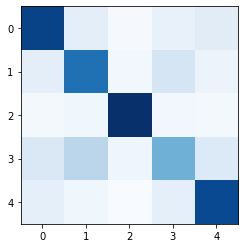

In [21]:
%%time
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(),
             metrics = ['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=100,
          epochs=50,
          verbose=0,
          validation_data=(x_test,y_test),
          shuffle = True
         )

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_raw = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_raw, y_pred)
print(cm)
print(classification_report(y_test_raw, y_pred))
plt.imshow(cm, cmap=plt.cm.Blues)

Di seguito vengono mostrate accuracy e loss in funzione delle epochs

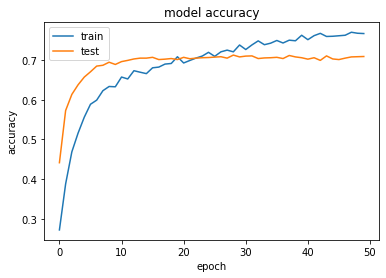

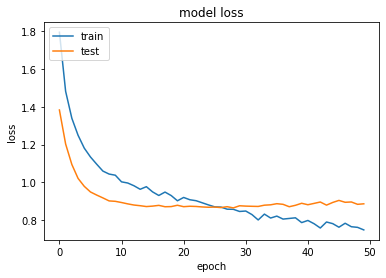

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2) Convolutional Neural Network (CNN)

Il secondo modello è una rete con 2 strati convoluzionali; la composizione è la seguente:  
- 2 strati convoluzionali con attivazione relu  
- Dropout  
- MaxPooling  
- Flatten  
- Fully connected, 100 nodi, con attivazione relu  e regolarizzazione  
- Dropout  
- Fully connected, 50 nodi, con attivazione sigmoidale
- Dropout  
- Fully Connected di output

In [23]:
from keras import regularizers 
input_shape = x_train.shape

In [24]:
#Declaring, compiling, and running the model
cnn = keras.Sequential(
    [
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_shape[1], input_shape[2])),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.5),
        MaxPooling1D(pool_size=3),
        Flatten(),
        
        Dense(100, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=regularizers.l2(1e-4),
                                      activity_regularizer=regularizers.l2(1e-5)),
        Dropout(0.5),
        
        Dense(50, activation='sigmoid'),
        Dropout(0.4),
        
        Dense(num_classes, activation='softmax')
    ]
)

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 198, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 196, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4160)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               416100    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)              

Di seguito viene fittato il modello con ottimizzatore adam; vengono inoltre mostrate le metriche di performance e la confusion matrix

[[313  35   5  28  39]
 [ 35 256  11  59  21]
 [  9  14 339  10   8]
 [ 50  98  17 167  48]
 [ 31  15   2  31 305]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       420
           1       0.61      0.67      0.64       382
           2       0.91      0.89      0.90       380
           3       0.57      0.44      0.49       380
           4       0.72      0.79      0.76       384

    accuracy                           0.71      1946
   macro avg       0.70      0.71      0.70      1946
weighted avg       0.70      0.71      0.70      1946

Wall time: 2min 14s


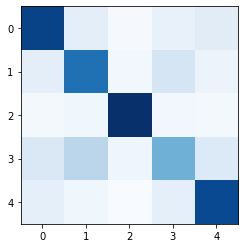

In [25]:
%%time
cnn.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(),
             metrics = ['accuracy'])

history_cnn = cnn.fit(x_train, y_train,
          batch_size=200,
          epochs=50,
          verbose=0,
          validation_data=(x_test,y_test),
          shuffle = True
         )

cnn_pred = model.predict(x_test)
cnn_pred = np.argmax(cnn_pred, axis=1)
y_test_raw = np.argmax(y_test, axis=1)
cm_cnn = confusion_matrix(y_test_raw, cnn_pred)
print(cm_cnn)
print(classification_report(y_test_raw, cnn_pred))
plt.imshow(cm_cnn, cmap=plt.cm.Blues)

Di seguito vengono mostrate accuracy e loss in funzione delle epochs

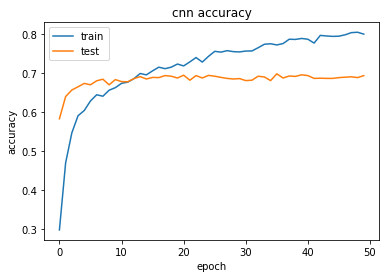

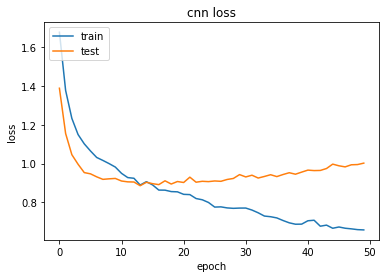

In [26]:
# summarize history for accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('cnn accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('cnn loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 3) SVM

Il terzo classificatore è una Support Vector Machine con kernel radial basis function. La parte commentata contiene il tuning dei parametri tramite Cross Validation

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score, GridSearchCV

x_train2, x_test2, y_train2, y_test2 = train_test_split(data, y, test_size=0.2, random_state=0)

x_train2 = np.squeeze(x_train2)
x_test2 = np.squeeze(x_test2)

In [28]:
'''#  Tuning parametri SVM
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(x_train2, y_train2)
print('Best score for training data:', svm_model.best_score_,"\n") 

print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
'''

'#  Tuning parametri SVM\nparams_grid = [{\'kernel\': [\'rbf\'], \'gamma\': [1e-3, 1e-4],\n                     \'C\': [1, 10, 100, 1000]}]\nsvm_model = GridSearchCV(SVC(), params_grid, cv=5)\nsvm_model.fit(x_train2, y_train2)\nprint(\'Best score for training data:\', svm_model.best_score_,"\n") \n\nprint(\'Best C:\',svm_model.best_estimator_.C,"\n") \nprint(\'Best Kernel:\',svm_model.best_estimator_.kernel,"\n")\nprint(\'Best Gamma:\',svm_model.best_estimator_.gamma,"\n")\n'

In [29]:
svm_model_rbf = SVC(kernel = 'rbf', C = 3, gamma = 'scale', shrinking = False, break_ties = True).fit(x_train2, y_train2) 
svm_predictions = svm_model_rbf.predict(x_test2) 

              precision    recall  f1-score   support

      Action       0.70      0.76      0.73       224
      Comedy       0.65      0.62      0.64       239
 Documentary       0.90      0.87      0.88       243
       Drama       0.62      0.58      0.60       259
      Horror       0.69      0.74      0.71       214

    accuracy                           0.71      1179
   macro avg       0.71      0.71      0.71      1179
weighted avg       0.71      0.71      0.71      1179



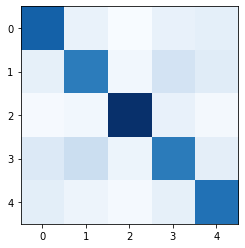

In [30]:
# creating a confusion matrix 
cm = confusion_matrix(y_test2, svm_predictions) 
print(classification_report(y_test2, svm_predictions))
plt.imshow(cm, cmap=plt.cm.Blues)

### 4) RandomForest

Il quarto modello è un classificatore Random Forest con 500 alberi e funzione di Gini

In [31]:
from sklearn.ensemble import RandomForestClassifier

label = pd.factorize(y)

x_train3, x_test3, y_train3, y_test3 = train_test_split(data, label[0], test_size=0.33, random_state=42)
x_train3 = np.squeeze(x_train3)
x_test3 = np.squeeze(x_test3)

In [32]:
classifier = RandomForestClassifier(n_estimators = 500, criterion = 'gini', random_state = 42)
classifier.fit(x_train3, y_train3)
y_pred3 = classifier.predict(x_test3)

              precision    recall  f1-score   support

           0       0.70      0.69      0.70       420
           1       0.58      0.65      0.61       382
           2       0.83      0.86      0.85       380
           3       0.55      0.44      0.49       380
           4       0.68      0.71      0.69       384

    accuracy                           0.67      1946
   macro avg       0.67      0.67      0.67      1946
weighted avg       0.67      0.67      0.67      1946



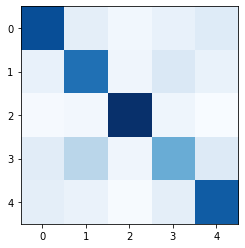

In [33]:
# creating a confusion matrix 
cm = confusion_matrix(y_test3, y_pred3) 
print(classification_report(y_test3, y_pred3))
plt.imshow(cm, cmap=plt.cm.Blues)

### 5) KNN

Il 5 e ultimo modello è un classificatore K-Nearest Neighbour 

In [34]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)

#Train the model using the training sets
knn.fit(x_train2, y_train2)

#Predict the response for test dataset
pred_knn = knn.predict(x_test2)

              precision    recall  f1-score   support

      Action       0.55      0.82      0.66       224
      Comedy       0.45      0.73      0.56       239
 Documentary       0.92      0.74      0.82       243
       Drama       0.50      0.24      0.32       259
      Horror       0.65      0.43      0.52       214

    accuracy                           0.59      1179
   macro avg       0.62      0.59      0.58      1179
weighted avg       0.62      0.59      0.57      1179



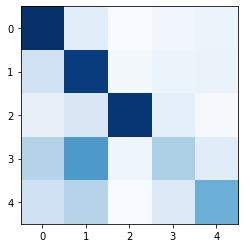

In [35]:
# creating a confusion matrix 
cm = confusion_matrix(y_test2, pred_knn) 
print(classification_report(y_test2, pred_knn))
plt.imshow(cm, cmap=plt.cm.Blues)